In [1]:
import os
os.environ['DJ_HOST']='localhost:3306'
os.environ['DJ_USER']='root'
os.environ['DJ_PASS']='nihil#751'

In [2]:
from nnfabrik.utility.dj_helpers import create_new_nnfabrik_module
from nnfabrik.utility.hypersearch import nnfabrikOptuna

# Schema name
schema_name = 'di_optuna_tf'
external_store = dict( 
                protocol = "file",
                location = "//jr-storage.ad.bcm.edu/jr-scratch03A/Nihil/trainedModels/"
)


# create schema
# Python module for this schema and db user name
nnModule, fabrikant_user_name = create_new_nnfabrik_module(schema_name, external_store, fabrikant_name='nihil',
                                                email_addr="nihil.patel@bcm.edu", affiliation="Reimerlab")
import warnings
warnings.filterwarnings('ignore')

C:\Users\-\miniconda3\envs\nnfabrik_keras\Lib\site-packages\datajoint\plugin.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
C:\Users\-\miniconda3\envs\nnfabrik_keras\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using local store at //jr-storage.ad.bcm.edu/jr-scratch03A/Nihil/trainedModels/


[2025-11-28 13:49:36,989][INFO]: DataJoint 0.14.6 connected to root@localhost:3306
[2025-11-28 13:49:37,146][INFO]: DataJoint 0.14.6 connected to root@localhost:3306


Schmea: root_di_optuna_tf is created in Database: localhost:3306!


## parts that are dynamic generated

In [3]:
import datajoint as dj

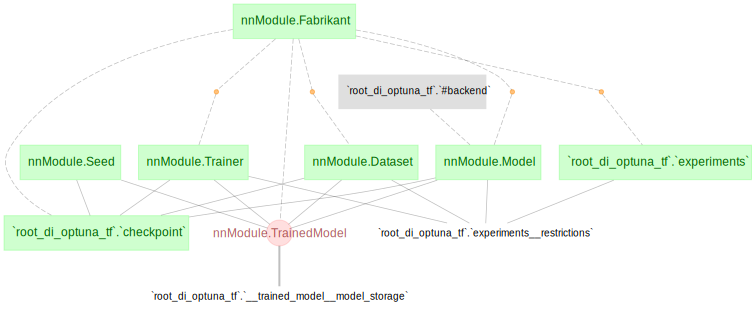

In [4]:
dj.Diagram(nnModule)

In [5]:
nnModule.Seed().insert([{'seed':0}], skip_duplicates=True) ## add more seeds to check model init stability

### Dataset

In [6]:
generator_param = {}
steps_per_epoch = 1


In [7]:
generator_param["steps_per_epoch"] = steps_per_epoch
generator_param["pre_post_frame"] = 30
generator_param["train_path"] = f"//jr-storage.ad.bcm.edu/jr-scratch03A/Nihil/corrected_scans/noura_data/33287_1_10_Fd1_Ch2_motionCorrected_1.tif"
generator_param["batch_size"] = 5
generator_param["start_frame"] = 0
generator_param["end_frame"] = 99
generator_param["pre_post_omission"] = 1
generator_param["nb_workers"]=1

In [8]:
generator_test_param = {'pre_post_frame': 30,
 'train_path': '//jr-storage.ad.bcm.edu/jr-scratch03A/Nihil/corrected_scans/noura_data/33287_1_10_Fd1_Ch2_motionCorrected_1.tif',
 'batch_size': 5,
 'start_frame': 0,
 'end_frame': 99,
 'pre_post_omission': 0,
 'steps_per_epoch': -1}


In [9]:
dataset_fn = "nnfabrik.examples.di_optuna.dataset.generator_function"
dataset_config = {'generator_params':generator_param,'test_generator_params': generator_test_param}
dataset_config_tune = {} # nothing to tune

### Model

In [10]:
model_fn = "nnfabrik.examples.di_optuna.model.di_model_function"
## parameters fixed for this study
model_config = {'backend_id': 1,'finetuning':True,'model_path':"../di_keras2.h5"}

## parameters to be tuned
model_config_tune = {}

### Trainer

In [11]:
import datetime
now = datetime.datetime.now()
run_uid = now.strftime("%Y_%m_%d_%H_%M")

In [12]:
training_param = {}
training_param["run_uid"]=run_uid
training_param['model_path']=model_config['model_path']
training_param['batch_size']=generator_test_param['batch_size']
training_param['steps_per_epoch']=steps_per_epoch
training_param['period_save']=25
training_param['nb_gpus']=1
training_param['apply_learning_decay']=0
training_param['nb_times_through_data']=1
training_param['loss']="mean_absolute_error"
training_param['pre_post_frame']= generator_test_param['pre_post_frame']
training_param['model_string']= ("transfer_"+training_param['loss']+"_"+training_param['run_uid'])
training_param['output_dir']= training_param['model_string']+"_"+run_uid

In [13]:
# specify trainer function as string (the function must be importable) as well as the trainer config
trainer_fn = "nnfabrik.examples.di_optuna.trainer.di_training_function"
trainer_config = training_param
trainer_config_tune =    {
    "learning_rate": {
        "method": "suggest_float",
        "args": {"name": "learning_rate", "low": 5e-7, "high": 5e-4, "log": True},
    }
}

## Configure Optuna study with nnfabrik as backend

In [14]:
study_config = dict(directions=["maximize"],study_name="di_nnfabrik_Optuna_kerasmodel_tfbackend")
opt_config = dict(n_trials=5, timeout=600, # in seconds
                 gc_after_trial  = True, show_progress_bar = True)

In [15]:
gps_study = nnfabrikOptuna(
        optuna_study_config = study_config, # optuna study related configurations
        optuna_optimization_config = opt_config , # optuna optimization related configurations
        dataset_fn = dataset_fn,
        dataset_config = dataset_config, # dictionary of fixed arguments for dataset function
        dataset_config_tune = dataset_config_tune, # dictionary of arguments for dataset function that are to be optimized
        model_fn = model_fn,
        model_config = model_config,
        model_config_tune = model_config_tune,
        trainer_fn= trainer_fn,
        trainer_config = trainer_config,
        trainer_config_tune = trainer_config_tune,
        architect = fabrikant_user_name,
        nn_module = nnModule # all python modules of this schema 
        )

## Run

In [16]:
nnModule.Trainer.delete_quick()
nnModule.Model.delete_quick()
nnModule.Dataset.delete_quick()

In [17]:
nnModule.Trainer()

trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,trainer_config training configuration object,trainer_fabrikant Name of the contributor that added this entry,trainer_comment short description,trainer_ts UTZ timestamp at time of insertion


In [ ]:
study = gps_study.run()

[I 2025-11-28 13:49:49,435] A new study created in memory with name: di_nnfabrik_Optuna_kerasmodel_tfbackend
  0%|          | 0/5 [00:00<?, ?it/s]WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.3371


## Explore results

In [25]:
nnModule.Dataset.fn_config

In [22]:
nnModule.Model.fetch('model_config')

array([{'backend_id': 2, 'h_dim': 2}, {'backend_id': 2, 'h_dim': 4},
       {'backend_id': 2, 'h_dim': 3}], dtype=object)

In [11]:
print("Pruner:", study.pruner)
print("Direction:", study.direction)
print("Sampler:", study.sampler)

Pruner: <optuna.pruners._median.MedianPruner object at 0x000001A260EF7490>
Direction: 2
Sampler: TPESampler


In [12]:
from optuna.trial import TrialState

all_trials = study.trials
completed = [t for t in all_trials if t.state == TrialState.COMPLETE]
pruned = [t for t in all_trials if t.state == TrialState.PRUNED]
failed = [t for t in all_trials if t.state == TrialState.FAIL]

print(f"Total trials: {len(all_trials)}")
print(f"Completed trials: {len(completed)}")
print(f"Pruned trials: {len(pruned)}")
print(f"Failed trials: {len(failed)}")

for t in pruned:
    print(f"Trial {t.number} was pruned. Intermediate values: {t.intermediate_values}")
for t in failed:
    print(f"Trial {t.number} failed. Error: {t.system_attrs.get('fail_reason')}")
print('Best trial')
study.best_trial

Total trials: 3
Completed trials: 3
Pruned trials: 0
Failed trials: 0
Best trial


FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, values=[73.44333333333333], datetime_start=datetime.datetime(2025, 11, 26, 12, 47, 35, 815805), datetime_complete=datetime.datetime(2025, 11, 26, 12, 51, 7, 476444), params={'hidden_dimension': 4, 'learning_rate': 0.0003901226333357849}, user_attrs={'trial_restriction': ('dataset_fn in ("nnfabrik.examples.mnist_optuna_torch.dataset.mnist_dataset_fn")', 'dataset_hash in ("1fb52248b88880405ed4585ebd69e1f9")', 'model_fn in ("nnfabrik.examples.mnist_optuna_torch.model.mnist_model_fn")', 'model_hash in ("e04f4a28312a49bfec4676fe74ab3a16")', 'trainer_fn in ("nnfabrik.examples.mnist_optuna_torch.trainer.mnist_trainer_fn")', 'trainer_hash in ("bef3aa1830720105cf641376825406e3")')}, system_attrs={}, intermediate_values={}, distributions={'hidden_dimension': IntDistribution(high=5, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None)}, trial_id=0, value=None)

In [13]:
nnModule.Model()

model_fn name of the model function,model_hash hash of the model configuration,backend_id,model_config model configuration to be passed into the function,model_fabrikant Name of the contributor that added this entry,model_comment short description,model_ts UTZ timestamp at time of insertion
nnfabrik.examples.mnist_optuna_torch.model.mnist_model_fn,551e6aba4b39866e8ec73634125d3001,2,=BLOB=,nihil,h_dim.5,2025-11-26 12:54:52
nnfabrik.examples.mnist_optuna_torch.model.mnist_model_fn,c51c460eda983cb52c541294ee91a2bb,2,=BLOB=,nihil,h_dim.2,2025-11-26 12:51:07
nnfabrik.examples.mnist_optuna_torch.model.mnist_model_fn,e04f4a28312a49bfec4676fe74ab3a16,2,=BLOB=,nihil,h_dim.4,2025-11-26 12:47:35


In [17]:
os.environ.items()

ItemsView(environ({'ALLUSERSPROFILE': 'C:\\ProgramData', 'APPDATA': 'C:\\Users\\-\\AppData\\Roaming', 'CHOCOLATEYINSTALL': 'C:\\ProgramData\\chocolatey', 'CHOCOLATEYLASTPATHUPDATE': '133099023469611990', 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'COMPUTERNAME': 'NZ', 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe', 'CONDA_DEFAULT_ENV': 'nnfabrik_keras', 'CONDA_PREFIX': 'C:\\Users\\-\\miniconda3\\envs\\nnfabrik_keras', 'CONDA_PROMPT_MODIFIER': '(nnfabrik_keras) ', 'CONDA_SHLVL': '1', 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData', 'EFC_69756_1592913036': '1', 'HOMEDRIVE': 'C:', 'HOMEPATH': '\\Users\\-', 'IPY_INTERRUPT_EVENT': '2716', 'JPY_INTERRUPT_EVENT': '2716', 'JPY_PARENT_PID': '2864', 'JPY_SESSION_NAME': 'C:\\Users\\-\\Documents\\nnfabrik-keras3\\nnfabrik\\examples\\notebooks\\mnist_nnfabrikOptuna.ipynb', 'KUBECONFIG': 'C:\\Users\\-\\.k

In [14]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_hidden_dimension,params_learning_rate,user_attrs_trial_restriction,state
0,0,73.443333,2025-11-26 12:47:35.815805,2025-11-26 12:51:07.476444,0 days 00:03:31.660639,4,0.000390,"(dataset_fn in (""nnfabrik.examples.mnist_optun...",COMPLETE
1,1,65.038333,2025-11-26 12:51:07.784799,2025-11-26 12:54:52.398658,0 days 00:03:44.613859,2,0.001902,"(dataset_fn in (""nnfabrik.examples.mnist_optun...",COMPLETE
2,2,19.956667,2025-11-26 12:54:52.722433,2025-11-26 12:58:37.936255,0 days 00:03:45.213822,5,0.071663,"(dataset_fn in (""nnfabrik.examples.mnist_optun...",COMPLETE


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

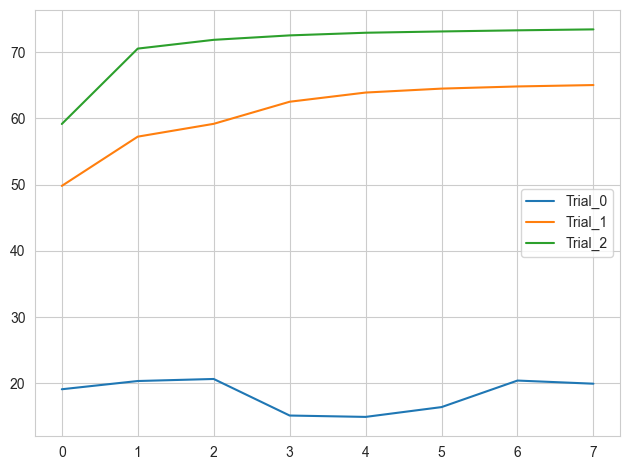

In [16]:
tmods = nnModule.TrainedModel.fetch('output', 'comment', 'score', as_dict=True)
fig = plt.figure()
accs = []
for idx, tmod1 in enumerate(tmods):
    accs.append(tmod1['output'][0]) # loss
    plt.plot(accs[-1], label=f'Trial_{idx}')
plt.legend()
plt.tight_layout()

In [28]:
nnModule.Model()

model_fn name of the model function,model_hash hash of the model configuration,backend_id,model_config model configuration to be passed into the function,model_fabrikant Name of the contributor that added this entry,model_comment short description,model_ts UTZ timestamp at time of insertion
nnfabrik.examples.mnist_optuna.model.mnist_model_fn,c51c460eda983cb52c541294ee91a2bb,2,=BLOB=,nihil,h_dim.2,2025-11-26 10:01:42
nnfabrik.examples.mnist_optuna.model.mnist_model_fn,e04f4a28312a49bfec4676fe74ab3a16,2,=BLOB=,nihil,h_dim.4,2025-11-26 10:04:05
nnfabrik.examples.mnist_optuna.model.mnist_model_fn,efd2384119eec83c013e33be56a49568,2,=BLOB=,nihil,h_dim.3,2025-11-26 09:59:07


In [32]:
nnModule.Dataset.fetch1('dataset_fn')

'nnfabrik.examples.mnist_optuna.dataset.mnist_dataset_fn'